In [1]:
import os 
import pandas as pd
import numpy as np

# import sklearn methods 
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
import sys 
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

In [2]:
# display test scores and return result string and indexes of false samples
def display_test_scores(test, pred):
    str_out = ""
    str_out += ("TEST SCORES\n")
    str_out += ("\n")

    #print accuracy
    accuracy = accuracy_score(test, pred)
    str_out += ("ACCURACY: {:.4f}\n".format(accuracy))
    str_out += ("\n")
    
    #print confusion matrix
    str_out += ("CONFUSION MATRIX:\n")
    conf_mat = confusion_matrix(test, pred)
    str_out += ("{}".format(conf_mat))
    str_out += ("\n")
    str_out += ("\n")

    #print FP, FN
    str_out += ("FALSE POSITIVES:\n")
    fp = conf_mat[1][0]
    pos_labels = conf_mat[1][0]+conf_mat[1][1]
    str_out += ("{} out of {} positive labels ({:.4f}%)\n".format(fp, pos_labels,fp/pos_labels))
    str_out += ("\n")

    str_out += ("FALSE NEGATIVES:\n")
    fn = conf_mat[0][1]
    neg_labels = conf_mat[0][1]+conf_mat[0][0]
    str_out += ("{} out of {} negative labels ({:.4f}%)\n".format(fn, neg_labels, fn/neg_labels))
    str_out += ("\n")

    
    #print classification report
    str_out += ("PRECISION, RECALL, F1 scores:\n")
    str_out += ("{}".format(classification_report(test, pred)))
    
    false_indexes = np.where(test != pred)
    return str_out, false_indexes

# RLDD DATA

The best parameters are {} with a score of 0.7046
TEST SCORES

ACCURACY: 0.7041

CONFUSION MATRIX:
[[162382  20143  16359]
 [ 53006 113457  31857]
 [ 29737  26468 146688]]

FALSE POSITIVES:
53006 out of 166463 positive labels (0.3184%)

FALSE NEGATIVES:
20143 out of 182525 negative labels (0.1104%)

PRECISION, RECALL, F1 scores:
              precision    recall  f1-score   support

           0       0.66      0.82      0.73    198884
           1       0.71      0.57      0.63    198320
           2       0.75      0.72      0.74    202893

    accuracy                           0.70    600097
   macro avg       0.71      0.70      0.70    600097
weighted avg       0.71      0.70      0.70    600097



([<matplotlib.patches.Wedge at 0x7facbf021d50>,
 [Text(-0.2299890676697397, 1.0756881652004935, 'n_EAR'),
  Text(-0.7520203898739988, 0.8027859821980944, 'n_MAR'),
  Text(-1.0843944777340984, 0.18463102843182175, 'n_MOE'),
  Text(-1.0583729663508075, -0.2997443312187787, 'n_EC'),
  Text(0.23745263081357915, -1.0740652904361587, 'n_LEB'),
  Text(1.0767842678725148, 0.22480133554374665, 'n_SOP'),
  Text(0.6691258756693276, 0.8730810744196417, 'PERCLOS'),
  Text(0.06388036289753847, 1.0981435695008548, 'CLOSENESS')],
 [Text(-0.12544858236531253, 0.5867389992002691, '6.70%'),
  Text(-0.410192939931272, 0.43788326301714237, '10.55%'),
  Text(-0.5914878969458718, 0.10070783369008458, '10.12%'),
  Text(-0.5772943452822585, -0.16349690793751562, '4.03%'),
  Text(0.12951961680740678, -0.5858537947833593, '44.11%'),
  Text(0.5873368733850081, 0.12261891029658907, '5.52%'),
  Text(0.3649777503650877, 0.4762260405925317, '17.12%'),
  Text(0.034843834307748255, 0.5989874015459208, '1.85%')])

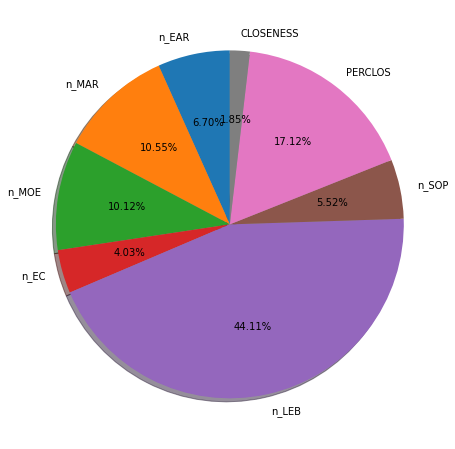

In [3]:
df_original = pd.read_pickle('../input/rlddandmerged/rldd_normalized_scaled.pkl')

X = df_original.loc[:, ["n_EAR", 
                    "n_MAR", "n_MOE", "n_EC",
                    "n_LEB", "n_SOP", "PERCLOS", "CLOSENESS"]]

y = df_original.loc[:, "DROWSINESS"].map({0: 0, 0.5: 1, 1:2})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

# cross-validation with 5 splits
cross_val = StratifiedShuffleSplit(n_splits=10, random_state = 42)

rf = RandomForestClassifier(random_state = 0,n_estimators=100,max_depth=10)

# parameters 
parameters = {  
#                "n_estimators":[100],
#                "criterion": ["gini","entropy"],
#                "class_weight": [None, "balanced_subsample"],
#                "max_features":[None, "sqrt"],
                }

# grid search for parameters
grid = GridSearchCV(estimator=rf, param_grid=parameters, cv=cross_val, n_jobs=-1)#multithreading; all cores are used
grid.fit(X_train, y_train)

# print best scores
print("The best parameters are %s with a score of %0.4f"
      % (grid.best_params_, grid.best_score_))

# prediction results
y_pred = grid.predict(X_test)

# print accuracy metrics
results, false = display_test_scores(y_test, y_pred)
print(results)

# plot importances
labels = X_train.columns
plt.figure(figsize=(8,8))
plt.pie(grid.best_estimator_.feature_importances_, labels=labels, shadow=True, startangle=90, autopct='%1.2f%%') 